In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

import itertools as it
from collections import Counter, defaultdict, deque

In [3]:
# ---------- Functional utils ---------- #
from toolz import pipe
from toolz.curried import *
max = curry(max)
min = curry(min)
call = lambda f: f()
@curry
def attr(name, obj):
    return getattr(obj, name)
@curry
def invoke(name, obj):
    return getattr(obj, name)()

lmap = curry(compose(list, map))
amap = curry(compose(np.array, lmap))

In [4]:
from agents import *
from envs import LinearEnv
env = LinearEnv(penalty=-1)
agent = Agent()
agent.register(env)
Q = ActionValueFunction()
# Q2= ActionValueFunction()
V = StateValueFunction()
agent.register(Q)
agent.register(V)
agent.register(MaxQPolicy(Q))
trace = agent.run_many(1000, max_steps=50)

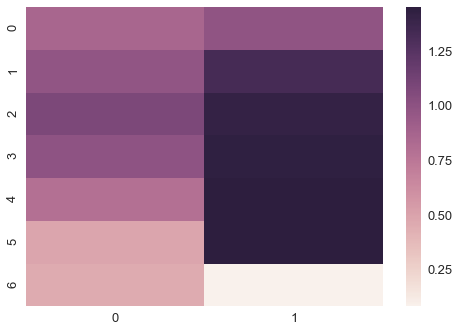

In [5]:
sns.heatmap(Q.model.theta)

In [6]:
N_EP = 100
from envs import ForageWorld
from agents import SearchAgent
env = ForageWorld(8, 5, .05)
agent = SearchAgent(env)
env.render()
trace = agent.run_many(N_EP, max_steps=100)
# print(agent.run_episode()['return'])

TypeError: __init__() takes 1 positional argument but 2 were given

In [62]:
N_EP = 5
from agents import*
from envs import ForageWorld
env = ForageWorld(8, 5, .05)
agent = Agent()
agent.register(env)
V = LinearV()
agent.register(V)
agent.register(SearchPolicy(V))
# agent.register(RandomPolicy())
trace = agent.run_many(N_EP, max_steps=100)

29 10.42 False
31 1.5 True
26 3.36 False
21 12.36 False
21 9.28 False
29 2.6 True
33 5.23 False
37 8.88 False
22 20.83 False
28 26.27 False
30 9.93 False
28 13.74 False
10 38.82 False
25 17.68 False
23 11.44 False
14 19.61 False
32 10.46 False
35 13.35 False



In [75]:
agent.ep_trace.keys()
agent.ep_trace['finished']

False

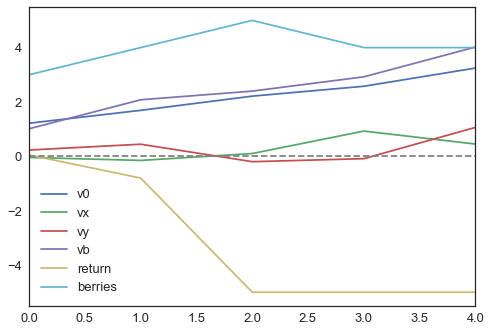

In [65]:
# N_EP = 50
# trace = agent.run_many(N_EP, max_steps=100)
roll = 1

df = pd.DataFrame(trace)
cols = ['v0', 'vx', 'vy', 'vb'] 
# cols.extend(['vxy', 'vxb', 'vyb'])
tdf = pd.DataFrame(list(df.theta_v), columns=cols).clip(-10, 100)
df = df.join(tdf).drop('theta_v', axis=1)
# sns.factorplot('berries', 'return', data=df)
# df['return'].rolling(roll).mean().plot()
# sns.lmplot('i_episode', 'vb', data=df)
df[cols + ['return', 'berries']].rolling(roll).mean().plot()
plt.axhline(0, ls='--', c='gray')

2.4420864917920477

In [38]:
from sklearn.linear_model import SGDRegressor
n_samples, n_features = 100, 5
X = np.random.randn(n_samples, n_features)
theta = np.random.randn(n_features)
y = X @ theta + 0.5 * np.random.randn(n_samples)
clf = SGDRegressor()
clf.fit(X, y)
theta_hat = np.linalg.inv(X.T @ X) @ (X.T @ y)
def rms_error(y1, y2):
    return ((y1 - y2) ** 2).mean() ** 0.5

print('{:.3f}  {:.3f}'.format(
    rms_error(y, clf.predict(X)),
    rms_error(y, X @ theta_hat)),
)


0.558  0.475


In [50]:
class LinearSGD(object):
    """Learns a linear approximation by SGD."""
    def __init__(self, shape, learn_rate=.1):
        self.shape = shape
        self.learn_rate = learn_rate
        self.theta = np.random.random(self.shape)

    def update(self, x, y):
        yhat = x @ self.theta
        error = y - yhat
        self.theta += self.learn_rate * np.outer(x, error)

    def predict(self, x):
        return x @ self.theta

mod = LinearSGD((n_features, 1), .1)
for i in range(len(X)):
    mod.update(X[i], y[i])

yhat = [mod.predict(x)[0] for x in X]
rms_error(y, yhat)

0.51021192985804253

In [14]:
from sklearn.linear_model import SGDRegressor
n_samples, n_features, n_output = 10, 5, 2
X = np.random.randn(n_samples, n_features)
theta = np.random.randn(n_features, n_output)
y = X @ theta
# clf = SGDRegressor()
# clf.partial_fit(X, y)
y

array([[ 2.42563877,  1.09444438],
       [ 1.59943738, -2.07547369],
       [ 1.020246  , -0.55091792],
       [ 2.60929959, -1.44009722],
       [-0.14960927, -0.90310834],
       [-2.22163198,  1.47699756],
       [-3.47033397, -1.74733514],
       [-2.26792348,  1.69821194],
       [-2.09173645,  1.45081708],
       [-6.32695908,  4.29277333]])

In [23]:
clf.fit(X, y)
theta_hat = np.linalg.inv(X.T @ X) @ (X.T @ y)
def rms_error(y1, y2):
    return ((y1 - y2) ** 2).mean() ** 0.5

print('{:.3f}  {:.3f}'.format(
    rms_error(y, clf.predict(X)),
    rms_error(y, X @ theta_hat)),
)

1.041  0.509


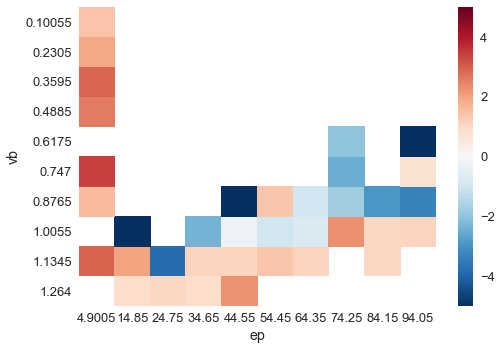

In [27]:
def bin(x):
    return pd.cut(x, 10).apply(lambda x: x.mid)

bdf = pd.DataFrame({
    'vb': bin(df.vb),
    'ep': bin(df.i_episode),
    'return': df['return']
})
sns.heatmap(bdf.pivot_table('return', 'vb', 'ep'))

In [128]:
agent.depth = 2
agent.run_episode()

{'actions': [2, 1, 0, 1, 3, 2, 1, 1, 2, 1, 2, 2],
 'finished': True,
 'i_episode': 4,
 'return': -22,
 'rewards': [-1, -1, -2, -2, -2, -1, -3, -2, -4, -3, -1, 0],
 'states': [0, 5, 6, 1, 2, 1, 6, 7, 8, 13, 14, 19, 24]}

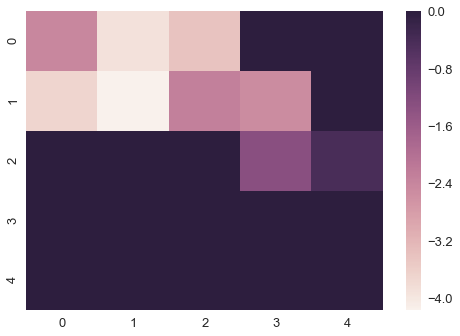

In [129]:
V = agent.V.to_array().reshape(5, 5)
sns.heatmap(V)

In [81]:
from agents import QLearningAgent
from envs import GridEnv

env = GridEnv(5, 5)
agent = QLearningAgent(env)
agent.Q.theta
# agent.Q.theta
# trace = agent.run_many(500)
agent.run_many(100)

[[ -1.336e+18   5.397e+16   6.329e+16   9.544e+14]
 [ -1.027e+18  -4.374e+16   8.271e+16   5.813e+10]]
[[ -3.293e+29   1.951e+30   1.634e+29   2.187e+30]
 [ -1.269e+29  -1.808e+31   6.028e+28   5.473e+29]]
[[ -2.126e+39   2.701e+42   3.233e+42   2.413e+41]
 [  4.245e+33  -2.503e+43   7.608e+37   6.080e+40]]
[[  2.289e+42   2.282e+45   4.025e+43   2.413e+41]
 [  2.291e+42   1.482e+45   4.085e+43   6.080e+40]]
[[  2.289e+42   6.671e+48   1.486e+50   2.413e+41]
 [  2.291e+42   8.901e+48   1.985e+50   6.080e+40]]
[[  5.822e+55   2.452e+53   3.535e+57   2.413e+41]
 [  1.163e+56   2.871e+53   6.401e+57   6.080e+40]]
[[ -5.012e+63   1.894e+64   1.922e+64   9.665e+62]
 [  1.163e+56  -1.924e+64   1.819e+64   6.080e+40]]
[[  6.734e+84   1.073e+86   3.175e+86   3.157e+85]
 [ -3.962e+81  -1.090e+86   4.231e+86   1.517e+80]]
[[  6.847e+113   8.623e+112  -2.240e+116   1.356e+103]
 [  2.337e+114   2.877e+115   2.416e+115  -1.868e+112]]
[[  3.360e+117   8.961e+121   4.039e+120  -3.961e+117]
 [  4.794e

/usr/local/lib/miniconda3/lib/python3.5/site-packages/numpy/core/numeric.py:1154: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis,:], out)
/Users/fred/Projects/gymrats/agents.py:170: RuntimeWarning: invalid value encountered in subtract
  error = y - yhat


[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]
[[ nan  nan  

{'finished': [True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False],
 'i_episode': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  

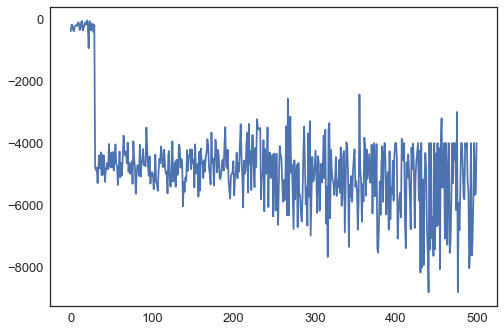

In [76]:
plt.plot(trace['return'])

[ -7.684  69.513]


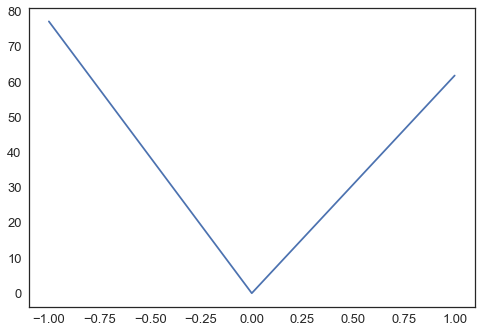

In [396]:
# agent.run_many(1000)
print(agent.V.theta)
# agent.V.theta = np.array([0, 100])
X = np.linspace(-1,1, 101)
plt.plot(X, lmap(agent.V, map(agent.phi, X)))